In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
from sindy_functions import *
from systems import *

In [5]:
x0=[0,1,20]

dt=0.001
tstamps=np.arange(0,1000,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

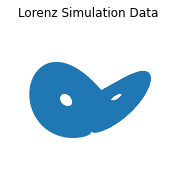

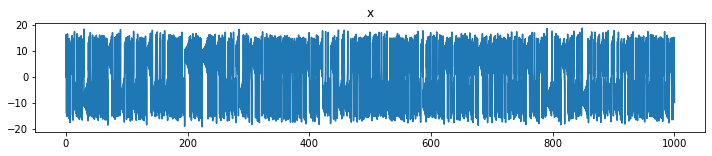

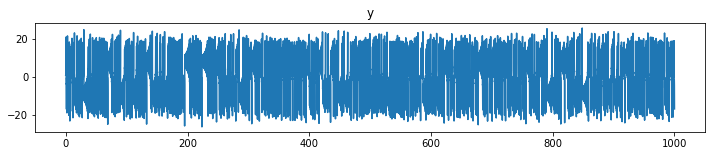

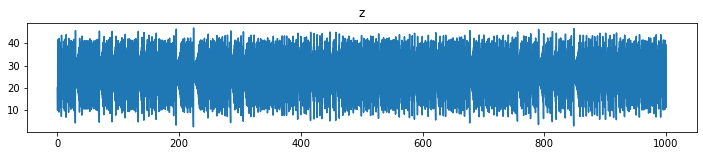

In [6]:
plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

In [7]:
Sol

array([[ 0.00000000e+00,  9.94531758e-03,  1.97825347e-02, ..., -9.55917337e+00, -9.62906001e+00, -9.69921005e+00],
       [ 1.00000000e+00,  9.99040517e-01,  9.98162136e-01, ..., -1.65344485e+01, -1.66310046e+01, -1.67271617e+01],
       [ 2.00000000e+01,  1.99467427e+01,  1.98936371e+01, ...,  1.61495785e+01,  1.62654559e+01,  1.63831144e+01]])

In [8]:
#x, x' normalisation - noise free

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([20,26,47])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=(Soldt.T/nc).T

#noise addition
#np.random.seed(1)
nlevel=0.001
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[0].shape)
nlevel=0.001
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[1].shape)
nlevel=0.001
#nSol=np.random.normal(nSol,nlevel/2)
nSol[2]=nSol[2]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[2].shape)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

#x, x' normalisation - with noise

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([20,26,47])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T

initial midpoint: [0 0 0]
initial variable normalisation constants (division): [20 26 47]
midpoint: [0 0 0]
variable normalisation constants (division): [20 26 47]


STLSQ result with unn, no noise

(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


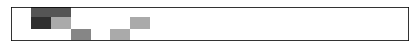

In [9]:
print('STLSQ result with unn, no noise')
print()

thres=0.1
deg=3
model = ps.SINDy(feature_names=["x","y","z"],optimizer=ps.STLSQ(threshold=thres),feature_library=ps.PolynomialLibrary(degree=deg))
model.fit(Sol[:,:].T, t=tstamps[:])
#model.print()
#print()
mc=model.coefficients()

lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=0,normalise=polypool((1e-0*lsw).reshape(1,-1),deg).tolist()[0])
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
ncuts=50
ncuts+=1
tps=(np.tile(np.arange(ncuts),2).reshape(2,-1).T.reshape(1,-1))[0][1:-1]
tps=tps*(len(tstamps)/(ncuts-1))
tps=tps.astype(int)
tps

array([      0,   20000,   20000,   40000,   40000,   60000,   60000,   80000,   80000,  100000,  100000,  120000,  120000,  140000,  140000,  160000,  160000,  180000,  180000,  200000,  200000,  220000,  220000,  240000,  240000,  260000,  260000,  280000,  280000,  300000,  300000,  320000,  320000,  340000,  340000,  360000,  360000,  380000,  380000,  400000,  400000,  420000,  420000,  440000,  440000,  460000,  460000,  480000,  480000,  500000,  500000,  520000,  520000,  540000,  540000,  560000,  560000,  580000,  580000,  600000,  600000,  620000,  620000,  640000,  640000,  660000,  660000,  680000,  680000,  700000,  700000,  720000,  720000,  740000,  740000,  760000,  760000,  780000,  780000,  800000,  800000,  820000,  820000,  840000,  840000,  860000,  860000,  880000,  880000,  900000,  900000,  920000,  920000,  940000,  940000,  960000,  960000,  980000,  980000, 1000000])

In [11]:
len(Sol.T)

1000000

In [12]:
nlevel=0.001
uSol=Sol+np.random.uniform(low=-nlevel,high=nlevel,size=Sol.shape)

In [13]:
randomise = np.arange(len(Sol.T))
np.random.shuffle(randomise)
rSol=uSol.T[randomise]
rSol=rSol.T
rSoldt=np.gradient(uSol[:,:],dt,axis=1).T[randomise]
rSoldt=rSoldt.T

In [14]:
mcs=[]
for i in np.arange(len(tps))[::2]:
    mc=re_SINDy(polypool(rSol[:,tps[i]:tps[i+1]].T,deg)
                ,rSoldt[:,tps[i]:tps[i+1]].T
                ,copy.deepcopy(model.coefficients()).T)
    mc=mc.T

    mcs.append(mc)

In [15]:
(np.average(mcs,axis=0)/np.std(mcs,axis=0))

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[            nan, -14414.16527214,  16315.71635589,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan],
       [            nan,   9182.95843247,   -928.72129422,             nan,             nan,             nan, -14142.76391139,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan],
       [            nan,             nan,             nan, -19897.70198215,             nan,  28783.80719273,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,             nan,      

In [16]:
WAS(mc,None)[0]

array([ 0.        ,  5.99747003,  3.00083988, -0.8888711 ,  0.        ,  0.33332645, -0.33327522,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


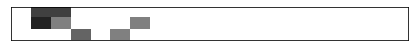

In [17]:
thres=0.01

lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(uSol[:,:].T,deg),np.gradient(uSol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise=polypool((1e-0*lsw).reshape(1,-1),deg).tolist()[0])
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-2,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

(x)' = -10.000 x + 13.000 y
(y)' = 21.537 x + -1.000 y + -36.152 x z
(z)' = -2.667 z + 11.064 x y


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


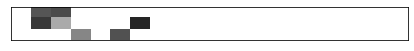

In [18]:
thres=0.01

lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(nSolnf[:,:].T,deg),np.gradient(nSolnf[:,:],dt,axis=1).T,thres,reg=1e-16,normalise=False)
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

(x)' = -10.000 x + 12.999 y
(y)' = 21.536 x + -0.999 y + -36.151 x z
(z)' = -2.667 z + 11.063 x y


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


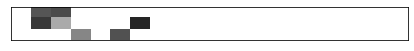

In [19]:
thres=0.8

lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(nSol[:,:].T,deg),np.gradient(nSol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise=False)
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
#x, x' normalisation - noise free

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([20,26,47])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=(Soldt.T/nc).T

#noise addition
#np.random.seed(1)
nlevel=0.004
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[0].shape)
#nlevel=0.001
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[1].shape)
#nlevel=0.001
#nSol=np.random.normal(nSol,nlevel/2)
nSol[2]=nSol[2]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[2].shape)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

#x, x' normalisation - with noise

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([20,26,47])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T

initial midpoint: [0 0 0]
initial variable normalisation constants (division): [20 26 47]
midpoint: [0 0 0]
variable normalisation constants (division): [20 26 47]


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":


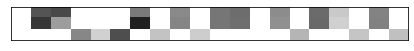

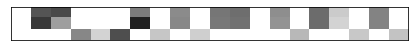

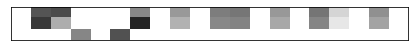

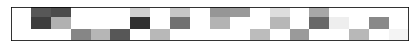

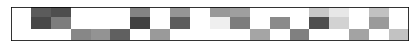

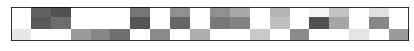

In [21]:
thres=0.1

for gamma in [1e-16,0.01,0.1,1,10,100]:

    lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
    mc=SINDy(polypool(nSol[:,:].T,deg),np.gradient(nSol[:,:],dt,axis=1).T,thres,reg=gamma,normalise=False)
    mc=mc.T
    model.coefficients()[:,:]=mc
    #model.print()

    plt.figure(figsize=(6,1))
    plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":


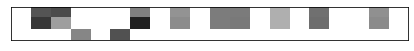

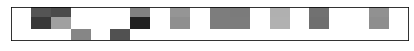

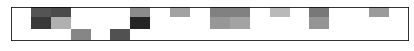

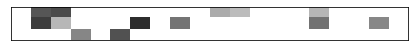

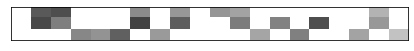

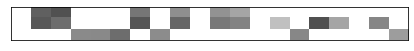

In [22]:
thres=0.5

for gamma in [1e-16,0.01,0.1,1,10,100]:

    lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
    mc=SINDy(polypool(nSol[:,:].T,deg),np.gradient(nSol[:,:],dt,axis=1).T,thres,reg=gamma,normalise=False)
    mc=mc.T
    model.coefficients()[:,:]=mc
    #model.print()

    plt.figure(figsize=(6,1))
    plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":


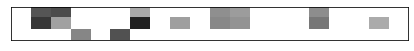

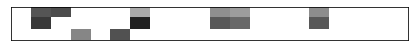

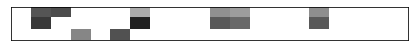

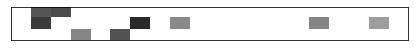

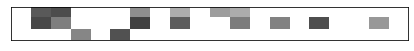

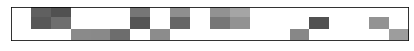

In [23]:
thres=0.9

for gamma in [1e-16,0.01,0.1,1,10,100]:

    lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
    mc=SINDy(polypool(nSol[:,:].T,deg),np.gradient(nSol[:,:],dt,axis=1).T,thres,reg=gamma,normalise=False)
    mc=mc.T
    model.coefficients()[:,:]=mc
    #model.print()

    plt.figure(figsize=(6,1))
    plt.imshow(np.log10(np.abs(model.coefficients())),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [24]:
umcs=[]
nmcs=[]

for iii in tnrange(1000):

    #x, x' normalisation - noise free

    midpoint=np.array([0,0,0])
    #midpoint=np.average(Sol,axis=1)
    #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
    #print('initial midpoint:',midpoint)
    Solm=Sol-np.reshape(midpoint,(-1,1))

    nc=np.abs(Solm.T).max(axis=0)
    nc=np.array([20,26,47])
    #print('initial variable normalisation constants (division):',nc)
    nSol=Solm.T/nc
    nSol=nSol.T
    nSolnf=np.copy(nSol)
    nSolnfdt=(Soldt.T/nc).T

    #noise addition
    #np.random.seed(1)
    nlevel=0.001
    #nSol=np.random.normal(nSol,nlevel/2)
    nSol[0]=nSol[0]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[0].shape)
    #nlevel=0.001
    #nSol=np.random.normal(nSol,nlevel/2)
    nSol[1]=nSol[1]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[1].shape)
    #nlevel=0.001
    #nSol=np.random.normal(nSol,nlevel/2)
    nSol[2]=nSol[2]+np.random.uniform(low=-nlevel,high=nlevel,size=nSol[2].shape)

    #implied noisy measurements - unnormalised
    uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

    #x, x' normalisation - with noise

    midpoint=np.array([0,0,0])
    #midpoint=np.average(Sol,axis=1)
    #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
    #print('midpoint:',midpoint)
    uSolm=uSol-np.reshape(midpoint,(-1,1))

    nc=np.abs(uSolm.T).max(axis=0)
    nc=np.array([20,26,47])
    #print('variable normalisation constants (division):',nc)
    nSol=uSolm.T/nc
    nSol=nSol.T
    
    deg=3
    thres=0
    
    #lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
    mc=SINDy(polypool(uSol[:,:].T,deg),np.gradient(uSol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise=False)
    mc=mc.T
    
    umcs.append(mc)
    
    #lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
    mc=SINDy(polypool(nSol[:,:].T,deg),np.gradient(nSol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise=False)
    mc=mc.T
    
    nmcs.append(mc)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
print(np.average(umcs,axis=0).round(2))

[[ 0.000e+00 -1.004e+01  1.002e+01 -0.000e+00 -0.000e+00 -0.000e+00  1.000e-02  0.000e+00 -0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  0.000e+00 -0.000e+00]
 [-0.000e+00  2.807e+01 -1.040e+00  0.000e+00  0.000e+00  0.000e+00 -1.010e+00 -0.000e+00  1.000e-02 -0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00]
 [-3.000e-02  0.000e+00 -0.000e+00 -2.660e+00 -0.000e+00  1.000e+00 -0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00]]


In [26]:
print(np.average(nmcs,axis=0).round(2))

[[ 0.000e+00 -1.004e+01  1.303e+01 -0.000e+00 -0.000e+00 -0.000e+00  3.200e-01  0.000e+00 -2.100e-01  0.000e+00  3.400e-01 -4.400e-01  0.000e+00  1.900e-01 -0.000e+00 -4.600e-01 -4.000e-02 -0.000e+00  2.500e-01 -0.000e+00]
 [-0.000e+00  2.159e+01 -1.040e+00  0.000e+00  0.000e+00  0.000e+00 -3.652e+01 -0.000e+00  2.400e-01 -0.000e+00 -3.400e-01  4.200e-01 -0.000e+00 -1.800e-01 -0.000e+00  5.000e-01  3.000e-02  0.000e+00 -2.600e-01  0.000e+00]
 [-0.000e+00  0.000e+00 -0.000e+00 -2.660e+00 -1.000e-02  1.111e+01 -0.000e+00 -2.000e-02  0.000e+00 -3.000e-02 -0.000e+00  0.000e+00 -1.000e-02 -0.000e+00 -3.000e-02  0.000e+00  0.000e+00  2.000e-02 -0.000e+00  4.000e-02]]


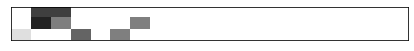

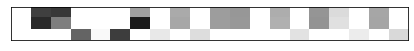

In [27]:
plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(np.average(umcs,axis=0))),cmap='gray_r',aspect='auto',vmin=-2,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(np.average(nmcs,axis=0))),cmap='gray_r',aspect='auto',vmin=-2,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [28]:
print(np.std(umcs,axis=0).round(3))

[[0.014 0.006 0.003 0.004 0.    0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.021 0.01  0.005 0.005 0.001 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.027 0.013 0.007 0.007 0.001 0.003 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [29]:
print(np.std(nmcs,axis=0).round(3))

[[0.001 0.006 0.004 0.008 0.009 0.034 0.032 0.019 0.022 0.031 0.027 0.038 0.014 0.021 0.022 0.041 0.005 0.017 0.025 0.035]
 [0.001 0.007 0.005 0.01  0.011 0.04  0.039 0.023 0.027 0.036 0.032 0.045 0.016 0.024 0.026 0.05  0.005 0.021 0.029 0.04 ]
 [0.001 0.006 0.004 0.007 0.008 0.03  0.029 0.017 0.02  0.026 0.025 0.035 0.012 0.019 0.02  0.038 0.004 0.015 0.022 0.03 ]]


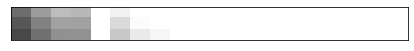

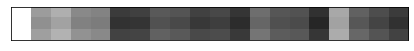

In [30]:
plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(np.std(umcs,axis=0))),cmap='gray_r',aspect='auto',vmin=-3,vmax=-1)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(np.std(nmcs,axis=0))),cmap='gray_r',aspect='auto',vmin=-3,vmax=-1)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()